In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers

# --- (Code Cell 1: TẠO DỮ LIỆU GIẢ LẬP VÀ XỬ LÝ SƠ BỘ) ---
NUM_USERS = 1000
NUM_ITEMS = 500
REVIEWS_PER_USER = 50
TOTAL_RECORDS = NUM_USERS * REVIEWS_PER_USER

items = [f'phone_{i}' for i in range(1, 101)] + [f'laptop_{i}' for i in range(1, 101)] + [f'clothes_{i}' for i in range(1, 301)]
user_ids = np.repeat(range(1, NUM_USERS + 1), REVIEWS_PER_USER)
item_ids = [random.choice(items) for _ in range(TOTAL_RECORDS)]
ratings = np.random.randint(1, 6, TOTAL_RECORDS)
vietnamese_reviews = [
    "Sản phẩm rất tốt, giao hàng nhanh chóng và đóng gói cẩn thận. Tôi rất hài lòng!",
    "Chất lượng sản phẩm không được như mong đợi, hơi thất vọng về trải nghiệm này.",
    "Mức giá hợp lý so với chất lượng. Sẽ mua lại lần sau.",
    "Đẹp, nhưng hơi bé so với hình. Cần xem xét lại kích thước.",
    "Tuyệt vời! Đáng tiền từng xu. Màu sắc và kiểu dáng đều ưng ý.",
    "Mình thấy bình thường, không có gì nổi bật. Dùng tạm ổn.",
]
reviews = [random.choice(vietnamese_reviews) for _ in range(TOTAL_RECORDS)]

data = pd.DataFrame({
    'UserID': user_ids, 'ItemID': item_ids, 'Rating': ratings, 'Review_VI': reviews
})

# --- (Code Cell 2: LOẠI BỎ STOP WORDS) ---
vietnamese_stopwords = ["là", "của", "và", "những", "một", "có", "không", "rất", "đã", "sẽ", "về", "trong", "cho", "tôi"]
def remove_stopwords(text, stopwords):
    if isinstance(text, str):
        return " ".join([word for word in text.split() if word.lower() not in stopwords])
    return text
data['Review_Clean'] = data['Review_VI'].apply(lambda x: remove_stopwords(x, vietnamese_stopwords))

# --- (Code Cell 3: CHUẨN HÓA RATING) ---
y_ratings = data['Rating'].values / 5.0 # Chuẩn hóa về [0.2, 1.0]

# --- (Code Cell 4: TOKENIZATION, CHIA TẬP DỮ LIỆU VÀ ĐỊNH NGHĨA KÍCH THƯỚC) ---
VOCAB_SIZE = 5000 
MAX_LENGTH = 100 
EMBEDDING_DIM = 50 # ĐỊNH NGHĨA BIẾN THIẾU

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Review_Clean'].values)
review_padded = pad_sequences(tokenizer.texts_to_sequences(data['Review_Clean'].values), maxlen=MAX_LENGTH)

user_id_map = {id: i + 1 for i, id in enumerate(data['UserID'].unique())}
item_id_map = {id: i + 1 for i, id in enumerate(data['ItemID'].unique())}

data['UserID_Idx'] = data['UserID'].map(user_id_map)
data['ItemID_Idx'] = data['ItemID'].map(item_id_map)

# ĐỊNH NGHĨA CÁC BIẾN THIẾU
NUM_USERS_UNIQUE = len(user_id_map)
NUM_ITEMS_UNIQUE = len(item_id_map)

X_train_reviews, X_test_reviews, X_train_users, X_test_users, X_train_items, X_test_items, y_train, y_test = train_test_split(
    review_padded, data['UserID_Idx'].values, data['ItemID_Idx'].values, y_ratings, test_size=0.2, random_state=42
)
X_val_reviews, X_test_reviews = X_test_reviews[:len(X_test_reviews)//2], X_test_reviews[len(X_test_reviews)//2:]
X_val_users, X_test_users = X_test_users[:len(X_test_users)//2], X_test_users[len(X_test_users)//2:]
X_val_items, X_test_items = X_test_items[:len(X_test_items)//2], X_test_items[len(X_test_items)//2:]
y_val, y_test = y_test[:len(y_test)//2], y_test[len(y_test)//2:]

print("Tất cả các biến chuẩn bị dữ liệu đã được định nghĩa.")

Tất cả các biến chuẩn bị dữ liệu đã được định nghĩa.


In [2]:
# --- Xây dựng Mô hình Collaborative Filtering (NCF) (Sửa lỗi NameError) ---
from tensorflow.keras import layers, Model, regularizers
import tensorflow as tf # Lặp lại import tf để đảm bảo có sẵn

# Định nghĩa Inputs
user_input = tf.keras.Input(shape=(1,), name='user_input')
item_input = tf.keras.Input(shape=(1,), name='item_input')

# User Embeddings (SỬA LỖI: dùng biến UNIQUE đã tính toán)
user_embedding = layers.Embedding(
    input_dim=NUM_USERS_UNIQUE + 1, 
    output_dim=EMBEDDING_DIM, 
    input_length=1, 
    name='user_embedding',
    embeddings_regularizer=regularizers.l2(0.001)
)(user_input)
user_vec = layers.Flatten()(user_embedding)

# Item Embeddings (SỬA LỖI: dùng biến UNIQUE đã tính toán)
item_embedding = layers.Embedding(
    input_dim=NUM_ITEMS_UNIQUE + 1, 
    output_dim=EMBEDDING_DIM, 
    input_length=1, 
    name='item_embedding',
    embeddings_regularizer=regularizers.l2(0.001)
)(item_input)
item_vec = layers.Flatten()(item_embedding)

# Kết hợp (Concatenate cho NCF)
concat = layers.concatenate([user_vec, item_vec])

# Mạng nơ-ron dày đặc (MLP layers)
dense = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concat)
dense = layers.Dropout(0.3)(dense) 
dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense)
dense = layers.Dropout(0.3)(dense)

# Dự đoán rating cuối cùng (output trong khoảng [0, 1])
output = layers.Dense(1, activation='sigmoid')(dense) 

cf_model = Model(inputs=[user_input, item_input], outputs=output)
cf_model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

print("\n--- Mô hình Neural Collaborative Filtering (NCF) đã được xây dựng ---")
cf_model.summary()


--- Mô hình Neural Collaborative Filtering (NCF) đã được xây dựng ---


C:\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 50)             │          50,050 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_embedding (Embedding)    │ (None, 1, 50)             │          25,050 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 50)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 50)                │               0 │ item_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 100)               │               0 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          12,928 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              65 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 96,349 (376.36 KB)

 Trainable params: 96,349 (376.36 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

# --- 1. Xây dựng Text Feature Model (CNN + LSTM) ---
vocab_size = VOCAB_SIZE + 1 # +1 cho OOV
max_review_length = MAX_LENGTH
text_embedding_dim = 100 # Kích thước embedding cho Word

# Input: Sequence of word indices
text_input = Input(shape=(max_review_length,), name='review_input')

# Embedding Layer (Word2vec-style, học trong quá trình huấn luyện)
embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=text_embedding_dim,
    input_length=max_review_length,
    name='word_embedding'
)(text_input)

# PHẦN 1: CNN để trích xuất Local Features/n-grams
conv_features = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
pooled_features = layers.GlobalMaxPooling1D()(conv_features)

# PHẦN 2: LSTM để nắm bắt Sequential Context
lstm_output = layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)(embedding) # Thêm Dropout/Recurrent Dropout

# KẾT HỢP Features từ CNN và LSTM
text_features = layers.concatenate([pooled_features, lstm_output], name='text_combined_features')

# MLP cuối cùng để tạo ra vector đặc trưng 32 chiều
dense = layers.Dense(64, activation='relu')(text_features)
dense = layers.Dropout(0.4)(dense) # Dropout chống Overfitting
text_output_vector = layers.Dense(32, activation='relu', name='text_feature_vector')(dense)

text_feature_model = Model(inputs=text_input, outputs=text_output_vector, name='Review_Feature_Model')

print("\n--- Mô hình Phân tích Review (CNN/LSTM) đã được xây dựng ---")
text_feature_model.summary()


--- Mô hình Phân tích Review (CNN/LSTM) đã được xây dựng ---


Model: "Review_Feature_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ review_input (InputLayer)     │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ word_embedding (Embedding)    │ (None, 100, 100)          │         500,100 │ review_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 96, 128)           │          64,128 │ word_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ conv1d[0][0]               │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          42,240 │ word_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_combined_features        │ (None, 192)               │               0 │ global_max_pooling1d[0][0… │
│ (Concatenate)                 │                           │                 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │          12,352 │ text_combined_features[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64)                │               0 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_feature_vector (Dense)   │ (None, 32)                │           2,080 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 620,900 (2.37 MB)

 Trainable params: 620,900 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras import Model, layers, regularizers, Input

# --- 2. Xây dựng Mô hình Hybrid (CF + Text) ---

# Inputs
hybrid_user_input = Input(shape=(1,), name='hybrid_user_input')
hybrid_item_input = Input(shape=(1,), name='hybrid_item_input')
hybrid_text_input = Input(shape=(MAX_LENGTH,), name='hybrid_review_input')

# 1. Lấy User/Item Feature (từ các lớp Embedding đã định nghĩa trong CF Model)
# Ta tái sử dụng các lớp embedding của cf_model
user_emb_layer = cf_model.get_layer('user_embedding')(hybrid_user_input)
item_emb_layer = cf_model.get_layer('item_embedding')(hybrid_item_input)

user_vec_hybrid = layers.Flatten(name='hybrid_user_vec')(user_emb_layer)
item_vec_hybrid = layers.Flatten(name='hybrid_item_vec')(item_emb_layer)

# 2. Lấy Text Feature (sử dụng Review Feature Model)
text_feature_vec = text_feature_model(hybrid_text_input)

# Kết hợp TẤT CẢ các features
# User vec (50) + Item vec (50) + Text feature vec (32) = 132 features
combined_all = layers.concatenate([user_vec_hybrid, item_vec_hybrid, text_feature_vec], name='all_combined_features')

# MLP cho dự đoán cuối cùng
dense_hybrid = layers.Dense(128, activation='relu', name='hybrid_dense_1')(combined_all)
# Áp dụng Dropout (Kỹ thuật chống Overfitting - g)
dense_hybrid = layers.Dropout(0.3, name='hybrid_dropout_1')(dense_hybrid)
# Áp dụng L2 Regularization (Kỹ thuật chống Overfitting - g)
dense_hybrid = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hybrid_dense_2_l2')(dense_hybrid)
dense_hybrid = layers.Dropout(0.3, name='hybrid_dropout_2')(dense_hybrid)

# Output (Dự đoán rating chuẩn hóa [0, 1])
hybrid_output = layers.Dense(1, activation='sigmoid', name='final_output')(dense_hybrid)

# Khởi tạo Mô hình Hybrid
hybrid_model = Model(
    inputs=[hybrid_user_input, hybrid_item_input, hybrid_text_input],
    outputs=hybrid_output,
    name='Hybrid_Recommender_System'
)

# Biên dịch mô hình (Loss: MSE, Metrics: RMSE, MAE)
hybrid_model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

print("\n--- Mô hình Hybrid (CF + Text) đã được xây dựng và Biên dịch ---")
hybrid_model.summary()


--- Mô hình Hybrid (CF + Text) đã được xây dựng và Biên dịch ---


Model: "Hybrid_Recommender_System"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hybrid_user_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_item_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 50)             │          50,050 │ hybrid_user_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_embedding (Embedding)    │ (None, 1, 50)             │          25,050 │ hybrid_item_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_review_input           │ (None, 100)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_user_vec (Flatten)     │ (None, 50)                │               0 │ user_embedding[1][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_item_vec (Flatten)     │ (None, 50)                │               0 │ item_embedding[1][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Review_Feature_Model          │ (None, 32)                │         620,900 │ hybrid_review_input[0][0]  │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ all_combined_features         │ (None, 132)               │               0 │ hybrid_user_vec[0][0],     │
│ (Concatenate)                 │                           │                 │ hybrid_item_vec[0][0],     │
│                               │                           │                 │ Review_Feature_Model[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_dense_1 (Dense)        │ (None, 128)               │          17,024 │ all_combined_features[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_dropout_1 (Dropout)    │ (None, 128)               │               0 │ hybrid_dense_1[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_dense_2_l2 (Dense)     │ (None, 64)                │           8,256 │ hybrid_dropout_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hybrid_dropout_2 (Dropout)    │ (None, 64)                │               0 │ hybrid_dense_2_l2[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ final_output (Dense)          │ (None, 1)                 │              65 │ hybrid_dropout_2[0][0]     │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 721,345 (2.75 MB)

 Trainable params: 721,345 (2.75 MB)

 Non-trainable params: 0 (0.00 B)


--- Bắt đầu Huấn luyện NCF Model ---

--- Bắt đầu Huấn luyện Hybrid Model ---

--- Đánh giá và So sánh Mô hình trên tập Test ---
NCF Model Test Loss/MAE/RMSE: 0.0806 / 0.2422 / 0.2838
Hybrid Model Test Loss/MAE/RMSE: 0.0806 / 0.2424 / 0.2838


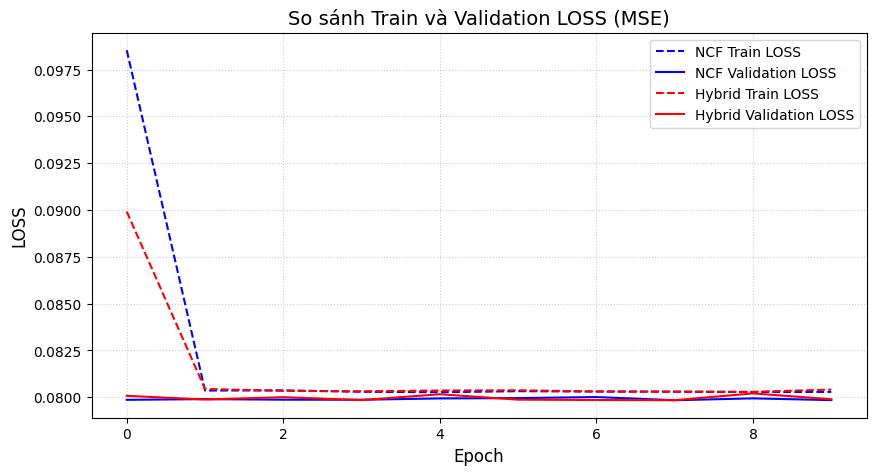

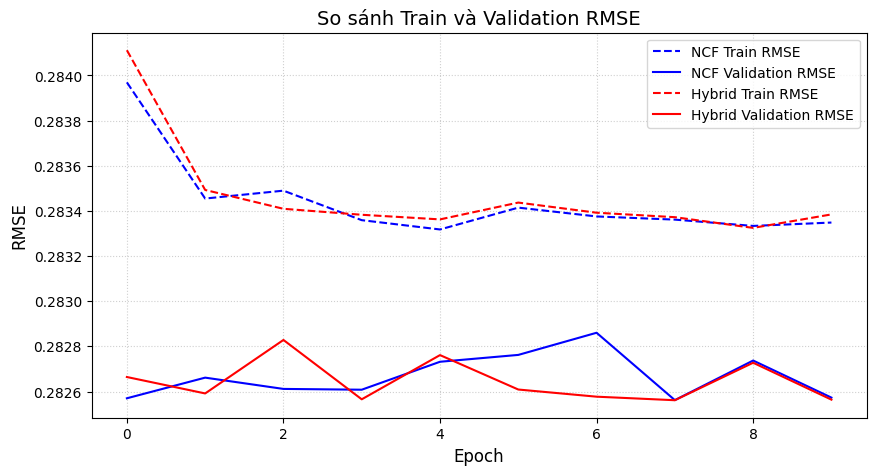

In [5]:
import matplotlib.pyplot as plt

# --- 3.1. Huấn luyện Mô hình NCF (CF_model) ---
print("\n--- Bắt đầu Huấn luyện NCF Model ---")
cf_history = cf_model.fit(
    [X_train_users, X_train_items],
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=([X_val_users, X_val_items], y_val),
    verbose=0 # Không hiển thị chi tiết để rút gọn output
)

# --- 3.2. Huấn luyện Mô hình Hybrid ---
print("\n--- Bắt đầu Huấn luyện Hybrid Model ---")
hybrid_history = hybrid_model.fit(
    [X_train_users, X_train_items, X_train_reviews],
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=([X_val_users, X_val_items, X_val_reviews], y_val),
    verbose=0 # Không hiển thị chi tiết để rút gọn output
)

# --- 3.3. Đánh giá trên tập Test (h) ---
print("\n--- Đánh giá và So sánh Mô hình trên tập Test ---")
cf_results = cf_model.evaluate([X_test_users, X_test_items], y_test, verbose=0)
hybrid_results = hybrid_model.evaluate([X_test_users, X_test_items, X_test_reviews], y_test, verbose=0)

print(f"NCF Model Test Loss/MAE/RMSE: {cf_results[0]:.4f} / {cf_results[1]:.4f} / {cf_results[2]:.4f}")
print(f"Hybrid Model Test Loss/MAE/RMSE: {hybrid_results[0]:.4f} / {hybrid_results[1]:.4f} / {hybrid_results[2]:.4f}")


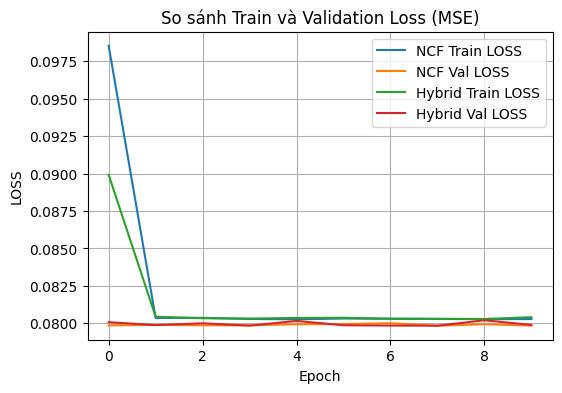

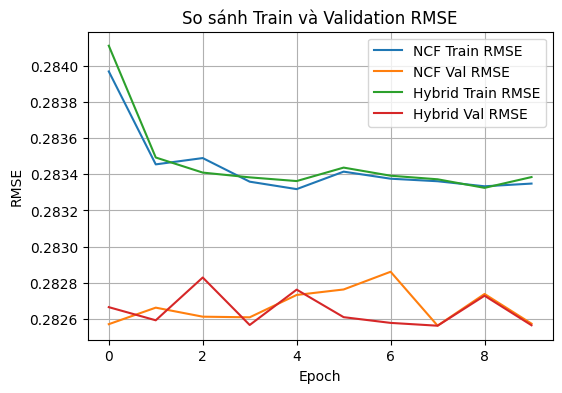

In [7]:
# --- Vẽ biểu đồ Loss và RMSE ---
def plot_history(cf_hist, hybrid_hist, metric, title):
    plt.figure(figsize=(6, 4))
    plt.plot(cf_hist.history[metric], label=f'NCF Train {metric.upper()}')
    plt.plot(cf_hist.history[f'val_{metric}'], label=f'NCF Val {metric.upper()}')
    plt.plot(hybrid_hist.history[metric], label=f'Hybrid Train {metric.upper()}')
    plt.plot(hybrid_hist.history[f'val_{metric}'], label=f'Hybrid Val {metric.upper()}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(cf_history, hybrid_history, 'loss', 'So sánh Train và Validation Loss (MSE)')
plot_history(cf_history, hybrid_history, 'rmse', 'So sánh Train và Validation RMSE')


